In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from datetime import datetime
import random

In [2]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [3]:
# Load your final preprocessed CSV file
df = pd.read_csv(r"C:\Users\Megha\jupyter\Solar-irradiance-code-files\data.csv")

"""
This script reads data from 'data.csv'.
Ensure the folder structure is:
- GRAtt.ipynb
- data.csv
"""

In [4]:
df.head()

,year,month,day,ALLSKY_SFC_SW_DWN,T2M,CLOUD_AMT,RH2M,HR_SIN,HR_COS,DAY_SIN,DAY_COS,SEASON_Autumn,SEASON_Monsoon,SEASON_Spring,SEASON_Summer,SEASON_Winter
0,2020,1,1,0.0,0.129363,0.7876,0.546526,0.000000,1.000000,0.974928,-0.222521,0,0,0,0,1
1,2020,1,1,0.0,0.114784,0.9109,0.573478,0.258819,0.965926,0.974928,-0.222521,0,0,0,0,1
2,2020,1,1,0.0,0.104723,0.8085,0.592334,0.500000,0.866025,0.974928,-0.222521,0,0,0,0,1
3,2020,1,1,0.0,0.095893,0.5953,0.611293,0.707107,0.707107,0.974928,-0.222521,0,0,0,0,1
4,2020,1,1,0.0,0.089733,0.5087,0.622976,0.866025,0.500000,0.974928,-0.222521,0,0,0,0,1


In [5]:
df.columns.tolist()

['year',
 'month',
 'day',
 'ALLSKY_SFC_SW_DWN',
 'T2M',
 'CLOUD_AMT',
 'RH2M',
 'HR_SIN',
 'HR_COS',
 'DAY_SIN',
 'DAY_COS',
 'SEASON_Autumn',
 'SEASON_Monsoon',
 'SEASON_Spring',
 'SEASON_Summer',
 'SEASON_Winter']

In [6]:
# Define features and target
features = ['T2M', 'CLOUD_AMT', 'RH2M', 'HR_SIN', 'HR_COS', 'DAY_SIN', 'DAY_COS'] + \
           [col for col in df.columns if col.startswith('SEASON_')]
target = 'ALLSKY_SFC_SW_DWN'

# Extract features and target
X = df[features].values
y = df[target].values

In [7]:
X.shape

(40176, 12)

In [8]:
y.shape

(40176,)

In [9]:
def create_sequences(data, target, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]  # Features
        y = target[i + seq_length]  # Target
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [10]:
seq_length = 24  # Example sequence length
X_seq, y_seq = create_sequences(X, y, seq_length)

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 4. Split into train, validation, and test sets
split_ratio = 0.7
split_index = int(len(X_seq) * split_ratio)

# 80% for training, 10% for validation, and 10% for testing
X_train, X_temp = X_seq[:split_index], X_seq[split_index:]
y_train, y_temp = y_seq[:split_index], y_seq[split_index:]

# Further split the remaining 30% into validation and test sets
val_split_ratio = 0.5  # 50% of the remaining data for validation
val_split_index = int(len(X_temp) * val_split_ratio)

X_val, X_test = X_temp[:val_split_index], X_temp[val_split_index:]
y_val, y_test = y_temp[:val_split_index], y_temp[val_split_index:]

# Create custom datasets for each split
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

# Create DataLoader for each dataset
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [14]:
for X_batch, y_batch in train_loader:
    print("X_batch shape:", X_batch.shape)  # should be (64, 24, 11)
    print("y_batch shape:", y_batch.shape)  # should be (64, 1)
    break

X_batch shape: torch.Size([64, 24, 12])
y_batch shape: torch.Size([64])


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Define GRU
# Enhanced Architecture Add-ons
class BoostedModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):  # Now accepts hidden_dim
        super().__init__()
        self.gru1 = nn.GRU(input_dim, hidden_dim, num_layers=2, dropout=0.2, batch_first=True)
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.Tanh(),
            nn.Linear(hidden_dim//2, 1),
            nn.Softmax(dim=1)
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.SiLU(),  # Swish activation
            nn.LayerNorm(hidden_dim//2),
            nn.Linear(hidden_dim//2, 1)
        )
        
    def forward(self, x):
        x, _ = self.gru1(x)
        attn_weights = self.attention(x)
        context = torch.sum(attn_weights * x, dim=1)
        return self.fc(context)

# Now you can initialize with your desired hidden_dim
model_m = BoostedModel(input_dim=X_train.shape[2], hidden_dim=64)  # This will work

# Training Protocol
optimizer = torch.optim.AdamW(model_m.parameters(), lr=3e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=5e-4, 
                                             steps_per_epoch=len(train_loader), 
                                             epochs=20)

# Define the loss function (MSE for regression)
criterion = nn.MSELoss()

In [16]:
from torch.optim import lr_scheduler

def train_model_with_history_fine_1(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_maes': [],
        'val_maes': [],
        'train_r2s': [],
        'val_r2s': []
    }
    
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        train_loss = 0
        train_mae = 0
        train_r2 = 0
        num_train_samples = 0
        
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(X_batch)  # Get predictions
            loss = criterion(outputs, y_batch.unsqueeze(1))  # Calculate MSE loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters
            
            train_loss += loss.item()
            
            # Calculate MAE
            mae = mean_absolute_error(y_batch.detach().numpy(), outputs.detach().numpy())
            train_mae += mae
            
            # Calculate R²
            r2 = r2_score(y_batch.detach().numpy(), outputs.detach().numpy())
            train_r2 += r2
            
            num_train_samples += 1
        
        train_loss /= num_train_samples
        train_mae /= num_train_samples
        train_r2 /= num_train_samples
        
        # Append to history (train metrics)
        history['train_losses'].append(train_loss)
        history['train_maes'].append(train_mae)
        history['train_r2s'].append(train_r2)
        
        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_loss = 0
        val_mae = 0
        val_r2 = 0
        num_val_samples = 0
        
        with torch.no_grad():  # No gradient calculation during validation
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch.unsqueeze(1))
                val_loss += loss.item()
                
                # Calculate MAE
                mae = mean_absolute_error(y_batch.detach().numpy(), outputs.detach().numpy())
                val_mae += mae
                
                # Calculate R²
                r2 = r2_score(y_batch.detach().numpy(), outputs.detach().numpy())
                val_r2 += r2
                
                num_val_samples += 1
        
        val_loss /= num_val_samples
        val_mae /= num_val_samples
        val_r2 /= num_val_samples
        
        # Append to history (validation metrics)
        history['val_losses'].append(val_loss)
        history['val_maes'].append(val_mae)
        history['val_r2s'].append(val_r2)
        
        # Print results for each epoch
        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"  Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}, Train R²: {train_r2:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}, Val R²: {val_r2:.4f}")
    
    return history

In [17]:
print(model_m)

BoostedModel(
  (gru1): GRU(12, 64, num_layers=2, batch_first=True, dropout=0.2)
  (attention): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=1, bias=True)
    (3): Softmax(dim=1)
  )
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): SiLU()
    (2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [18]:
# Re-train with the learning rate scheduler
history_fine_5 = train_model_with_history_fine_1(model_m, train_loader, val_loader, criterion, optimizer, epochs=20)

Epoch 1/20:
  Train Loss: 0.0546, Train MAE: 0.1886, Train R²: 0.2046
  Val Loss: 0.0389, Val MAE: 0.1566, Val R²: 0.4765
Epoch 2/20:
  Train Loss: 0.0256, Train MAE: 0.1267, Train R²: 0.6261
  Val Loss: 0.0181, Val MAE: 0.1083, Val R²: 0.7163
Epoch 3/20:
  Train Loss: 0.0195, Train MAE: 0.1132, Train R²: 0.7105
  Val Loss: 0.0152, Val MAE: 0.0995, Val R²: 0.7460
Epoch 4/20:
  Train Loss: 0.0165, Train MAE: 0.1040, Train R²: 0.7544
  Val Loss: 0.0125, Val MAE: 0.0892, Val R²: 0.7838
Epoch 5/20:
  Train Loss: 0.0135, Train MAE: 0.0929, Train R²: 0.7991
  Val Loss: 0.0100, Val MAE: 0.0779, Val R²: 0.8171
Epoch 6/20:
  Train Loss: 0.0110, Train MAE: 0.0818, Train R²: 0.8371
  Val Loss: 0.0079, Val MAE: 0.0663, Val R²: 0.8439
Epoch 7/20:
  Train Loss: 0.0092, Train MAE: 0.0730, Train R²: 0.8630
  Val Loss: 0.0070, Val MAE: 0.0587, Val R²: 0.8577
Epoch 8/20:
  Train Loss: 0.0081, Train MAE: 0.0670, Train R²: 0.8795
  Val Loss: 0.0065, Val MAE: 0.0544, Val R²: 0.8645
Epoch 9/20:
  Train Loss

In [19]:
from torchinfo import summary

## DIAGNOSTIC PLOTS:

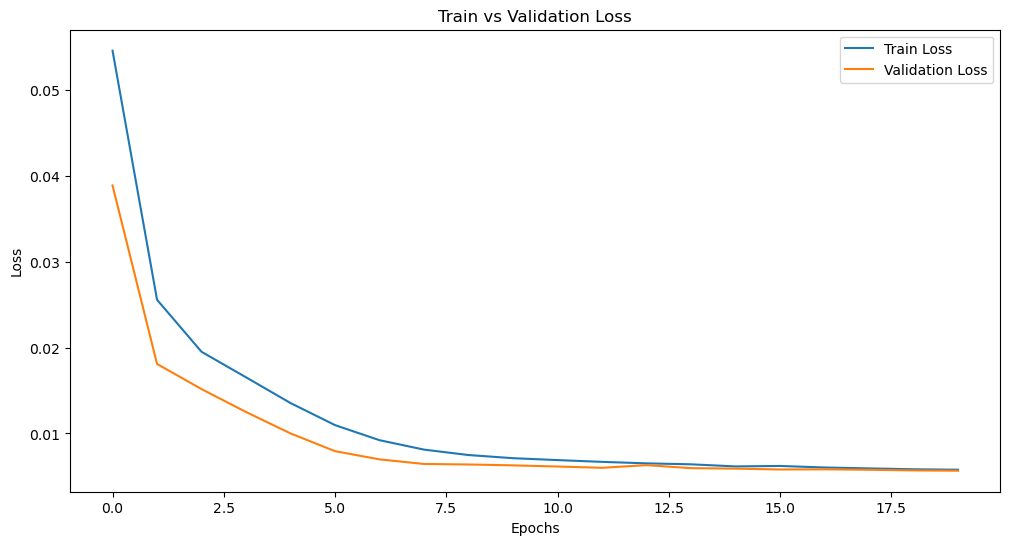

In [21]:
import matplotlib.pyplot as plt

# Plot train and validation losses
plt.figure(figsize=(12, 6))
plt.plot(history_fine_5['train_losses'], label='Train Loss')
plt.plot(history_fine_5['val_losses'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Validation Loss')
plt.show()

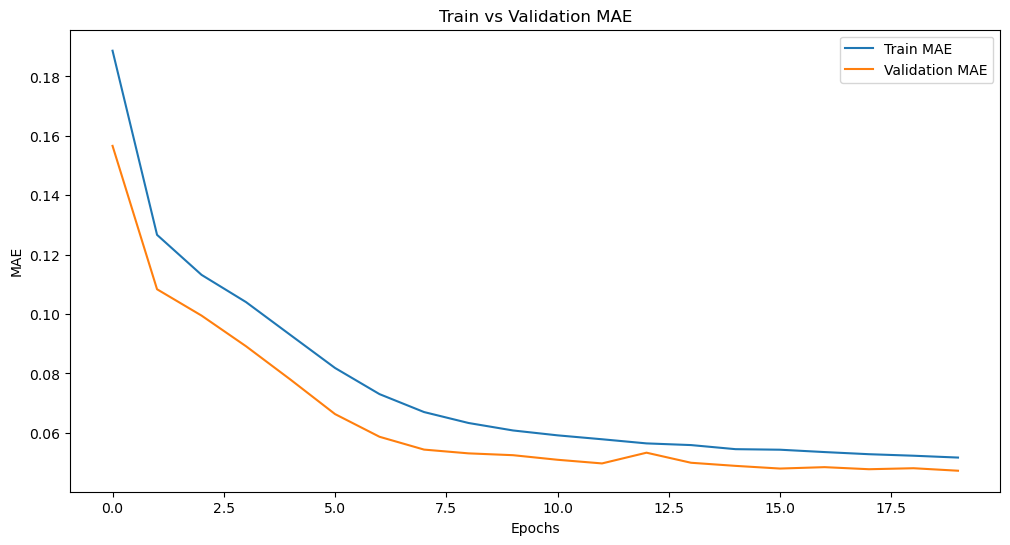

In [22]:
# Plot train and validation MAE
plt.figure(figsize=(12, 6))
plt.plot(history_fine_5['train_maes'], label='Train MAE')
plt.plot(history_fine_5['val_maes'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Train vs Validation MAE')
plt.show()

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score

import torch

# Define the device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move your model to the device (GPU or CPU)
model_m.to(device)

# Collecting predictions and true values
all_preds = []
all_true = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model_m(X_batch)
        all_preds.append(outputs.cpu())
        all_true.append(y_batch.cpu())

# Concatenate all batches
y_pred_tensor = torch.cat(all_preds)
y_true_tensor = torch.cat(all_true)

y_pred_np = y_pred_tensor.numpy().squeeze()
y_true_np = y_true_tensor.numpy().squeeze()

# Calculate MAE and R² for performance evaluation
mae = mean_absolute_error(y_true_np, y_pred_np)
r2 = r2_score(y_true_np, y_pred_np)


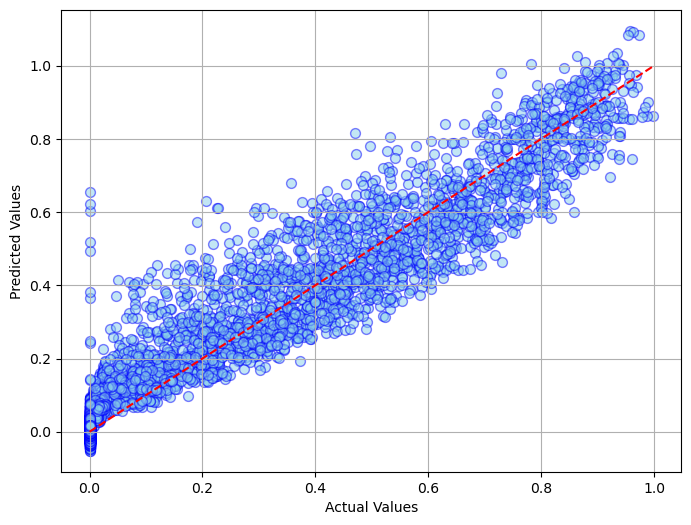

In [30]:
# Plot the actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred,
            s=50,             # Slightly larger markers
            alpha=0.5,        # Good transparency to show density
            color='skyblue',  # A pleasant color for the points
            edgecolors='blue', # Darker edge for better definition
            label='Data Points')
plt.plot([y_true_np.min(), y_true_np.max()], [y_true_np.min(), y_true_np.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Add MAE and R² to the title
plt.title('')
plt.grid(True)
plt.show()

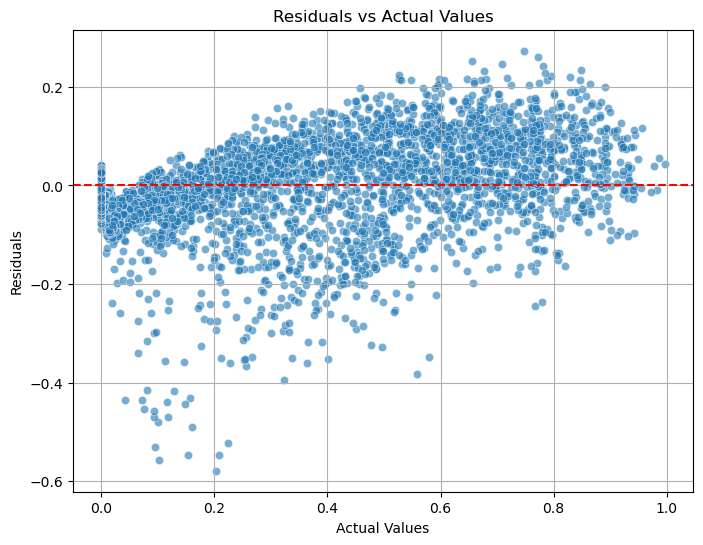

In [25]:
# Calculate residuals
residuals = y_true_np - y_pred_np

# Plot Residuals vs Actual Values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_true_np, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')  # Red dashed line at y=0
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Actual Values')
plt.grid(True)
plt.show()

## test scores:

In [26]:
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


y_true = []
y_pred = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model_m(X_batch)
        y_true.append(y_batch.numpy())
        y_pred.append(outputs.numpy())

# Concatenate all batches
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

In [27]:
# RMSE
test_rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# MAE
test_mae = mean_absolute_error(y_true, y_pred)

# R²
test_r2 = r2_score(y_true, y_pred)

print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R² Score: {test_r2:.4f}")

Test RMSE: 0.0747
Test MAE: 0.0492
Test R² Score: 0.9245


In [28]:
# 1-Hour MAE is essentially the same as MAE if your target is next-step prediction
one_hour_mae = mean_absolute_error(y_true, y_pred)

print(f"1-Hour MAE: {one_hour_mae:.4f}")

1-Hour MAE: 0.0492
